In [1]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
import math
import copy

import scipy
import scipy.io as sio


from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

In [2]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

In [3]:
from matplotlib.pyplot import cm
colors=cm.rainbow(np.linspace(0,1,10))

# 1 Load data

In [4]:
import scipy
import scipy.io as sio



In [5]:
row_idx = [];
for i in ['A','B','C','D','E','F']:
    for j in np.arange(1,9,1):
        row_idx.append(i+str(j))
row_idx.append('Time')

In [7]:
filename_OD = '../data/d20220817_ODphagecounting_M9Mal.mat';
mat_contents = sio.loadmat(filename_OD)
time_ = mat_contents['timeVector'][0]

df_mal = pd.DataFrame(mat_contents['blankedOD'])
df_mal.loc['Time'] = time_
df_mal.index = row_idx

578
266


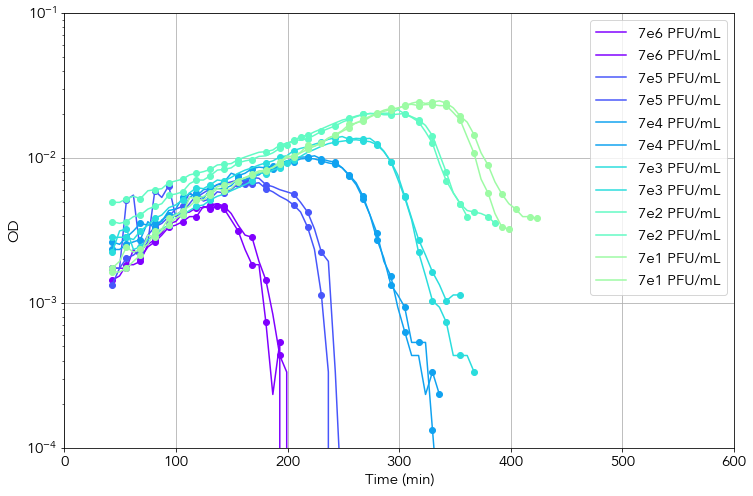

In [13]:
filtering_threshold = 1e-7; 

time_list = {};
OD_list = {};

all_data = 0;
reducde_data = 0; 

ndata_dict = {
    7:10,
    6: 20,
    5: 20,
    4: 20,
    3: 18,
    2: 15,
    1: 15,
}

matplotlib.rcParams.update({"figure.figsize": (12,8)})
k = 0;

i = 6; 
for conc in list(my_dict1.keys())[2:-2]:
    for j in my_dict1[conc]:
        x_ = df_mal.loc['Time'].to_numpy()[:130]
        y_ = df_mal.loc[j].to_numpy()[:130]
        
        if i == 7:
            y_tmp = y_[x_>100];
        else:
            y_tmp = y_[x_>100];
        
        idx = np.argmax(y_tmp) 
        
        idx = idx + len(y_) - len(y_tmp);
        
        vxx = x_[6:idx+ndata_dict[i]];
        vyy = y_[6:idx+ndata_dict[i]];
        
#        vyy[vyy<=1e-4] = 1e-4; 
        
        vyy1 = (vyy[1::2]-vyy[:-1:2])/(vxx[1::2]-vxx[:-1:2])
        vxx1 = vxx[:-1:2];
            
        vyy2 = (vyy1[1:]-vyy1[:-1])/(vxx1[1:]-vxx1[:-1])
        vxx2 = vxx1[:-1];
        
        idx_key = np.where(np.abs(vyy2) > filtering_threshold)[0]*2 + 2;#maybe 3? 
        
        if 0 not in idx_key:
            idx_key = np.append(idx_key, 0);
        
        if len(vyy2) not in idx_key:
            idx_key = np.append(idx_key, len(vyy2));
            
        if len(vyy)-1 not in idx_key:
            idx_key = np.append(idx_key, len(vyy)-1);
        
        idx_key = np.sort(idx_key)
        
        delete_idx = []; 
        for tmp_ in range(len(idx_key)):
            if vyy[idx_key[tmp_]] <= 1e-4:
                delete_idx.append(tmp_);
        idx_key = np.delete(idx_key, delete_idx)
        
        all_data += len(vxx);
        reducde_data += len(idx_key);
        
        
        plt.plot(vxx, vyy, color = colors[k],label=conc+' PFU/mL')
        plt.plot(vxx[idx_key], vyy[idx_key], 'o', color = colors[k,:])
        
        time_list[j] = vxx[idx_key];
        OD_list[j] = vyy[idx_key];
    i = i-1;
    k = k+1; 
plt.xlabel('Time (min)')
plt.ylabel('OD')
plt.yscale('log')
plt.xlim((0,600))
plt.grid(True)
plt.ylim((1e-4,0.1))
plt.legend(ncol=1)

print(all_data)
print(reducde_data)

In [14]:
c0 = np.mean(np.array([df_mal.loc['C5'].to_numpy()[6],df_mal.loc['C6'].to_numpy()[6]]))
p0 = 7.4*np.array([1e6, 1e6, 1e5, 1e5, 1e4, 1e4, 1e3, 1e3, 1e2, 1e2, 1e1, 1e1])

print(c0)

0.0017333341141541753


# 2 Fitting

In [15]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import copy

k1b_v = 2.11959188;
v1b_v = 0.02977562;
eb_v = 2.02934170;

def f0(x, t, ps):
    try:
        r = ps['r'].value
        b = ps['b'].value
        tau = ps['tau'].value
    except:
        r, b, tau = ps
    
    F, S, I1, I2, I3, I4, I5, P  = x; 
    
    F = max(0,F)
    S = max(0,S)
    I1 = max(0,I1)
    I2 = max(0,I2)
    I3 = max(0,I3)
    I4 = max(0,I4)
    I5 = max(0,I5)
    P = max(0,P)
    
    ####################
    M = 5;
    IM = I5; 
    I_all = I1+I2+I3+I4+I5; 
    
    v_ = v1b_v;
    k_ = k1b_v;
    e_ = eb_v;
    
    ####################
    
    phi = F/(k_+F);
    phi_max = 1/(k_+1); 
    relative_growth = phi/phi_max; 
    
    if S == 0 or P == 0:
        adsorption1 = 0;
    else:
        adsorption1 = np.exp(np.log(r) + np.log(S) + np.log(P))
    
    if S + I_all == 0 or P == 0:
        adsorption2 = 0; 
    else:
        adsorption2 = np.exp(np.log(r) + np.log(S+I_all) + np.log(P))
    
    lysis = M/tau*IM; 
    
    dF = -e_*phi*v_*(S+I_all); 
    dS = v_*phi*S - adsorption1; 
    dI1 = adsorption1 - M/tau*I1; 
    dI2 = M/tau*(I1-I2);
    dI3 = M/tau*(I2-I3);
    dI4 = M/tau*(I3-I4);
    dI5 = M/tau*(I4-I5);
    dP = b*lysis - adsorption2;

    return [dF,dS,dI1,dI2,dI3,dI4,dI5,dP]


def g0(t, x0, ps):
    x = odeint(f0, x0, t, args=(ps,))
    all_cell = x[:,1] + x[:,2] + x[:,3] + x[:,4] + x[:,5] + x[:,6]; 
    return all_cell

def residual0(ps, ts, time_list, OD_list):
    res_reweight = np.array([]); 
    time_list_keys = list(time_list.keys());
    
    i = 0; 
    for phage_conc in p0:
        x0 = [1, c0, 0, 0, 0, 0, 0, phage_conc/1e9];
        
        # obtain time list and OD list 
        time_raw = time_list[time_list_keys[i]];
        data_real = OD_list[time_list_keys[i]];

        # simulate OD
        data_simul = np.zeros(len(time_raw)); 
        OD_tmp = g0(ts, x0, ps);
        z = 0; 
        for j in time_raw:
            t_i = np.where(ts>j-time_raw[0])[0][0];
            data_simul[z] = OD_tmp[t_i];
            z = z+1;
        # update residual 
        range_real = np.max(np.log(data_real))-np.min(np.log(data_real));
        res_tmp = (np.log(data_simul) - np.log(data_real))/len(data_real)/range_real;
        res_reweight = np.append(res_reweight,res_tmp)
        
        i = i+1; 
    return res_reweight

In [ ]:
r_mal = np.zeros(N); 
b_mal = np.zeros(N); 
tau_mal = np.zeros(N); 

t_0 = time.time() 
for i_ in range(N):
    
    t = linspace(0,600,600);  
    params = Parameters()
    params.add('r', value=1, min=0.01, max=10)
    params.add('b', value=100, min=10, max=1000)
    params.add('tau', value=40, min=30, max=150)

    result = minimize(residual0, params, args=(t, time_list, OD_list), \
                  method='dual_annealing',nan_policy='omit')

    r_mal[i_] = result.params['r'].value;
    b_mal[i_] = result.params['b'].value;
    tau_mal[i_] = result.params['tau'].value;
    
elapsed = time.time() - t_0
print(elapsed)

In [19]:
colors=cm.turbo.reversed()(np.linspace(0,1,9))

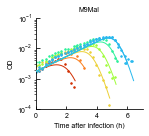

In [20]:
'''
rb = r_mal[0];
bb = b_mal[0]; 
taub = tau_mal[0]; 
'''
rb = 0.6342271623259587;
bb = 142.9565866036946;
taub = 51.80574403190663; 
colors_ = [1,1,2,2,3,3,4,4,5,5,6,6]

psb = [rb, bb, taub];
ts = linspace(0,600,600);


time_list_keys = list(time_list.keys());


#############
alpha_ = 1; 
marker_size_ = 1.5; 
line_width_ = 1; 
color_off_set = 1; 

fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
height = 1.9; 
scale_ratio = 1.1; 
matplotlib.rcParams.update({"figure.figsize": (height*scale_ratio,height)})

ax = plt.subplot(1,1,1)
#############

i = 0; 
for phage_conc in p0:
    power_ = int(np.log10(phage_conc/7.4)); 
    phage_concentration = 'P(0) = 7.4e'+str(power_) + ' PFU/mL'; 
    
    #subplot(3,4,i+1)
    #plt.title(phage_concentration)
    
    # obtain time list and OD list 
    time_cell = time_list[time_list_keys[i]];
    OD_cell = OD_list[time_list_keys[i]];
    
    x0 = [1, c0, 0, 0, 0, 0, 0, phage_conc/1e9];
        
    
    
    maxtime = int(max(time_cell) - time_cell[0])
    
    #simulate
    x = odeint(f0, x0, ts, args=(psb,))
    simul_cell = x[:,1] + x[:,2] + x[:,3] + x[:,4] + x[:,5] + x[:,6];
    
    if i in [0,2,4,6,8]:
        next;
    else:
        plt.plot((time_cell - time_cell[0])/60, OD_cell, \
             'o', markersize=marker_size_, \
             color=colors[colors_[i],:],zorder=0)
        plt.plot(ts[:maxtime+5]/60, simul_cell[:maxtime+5], \
             color=colors[colors_[i],:],\
             alpha=alpha_, linewidth=line_width_,zorder=10)
    i = i+1;
    
plt.title('M9Mal')
plt.xlabel('Time after infection (h)')
plt.ylim((1e-4,1e-1))
plt.yscale('log')
plt.ylabel('OD')
plt.xlim(0, 7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
#plt.tight_layout()
#plt.savefig('fS6_M9mal_v0.pdf', format='pdf', bbox_inches='tight')
    
plt.tight_layout()

# 3 MCMC

In [ ]:
def residual1(ps):
    res_reweight = np.array([]); 
    time_list_keys = list(time_list.keys());
    
    i = 0; 
    for phage_conc in p0:
        x0 = [1, c0, 0, 0, 0, 0, 0, phage_conc/1e9];
        
        # obtain time list and OD list 
        time_raw = time_list[time_list_keys[i]];
        data_real = OD_list[time_list_keys[i]];

        # simulate OD
        data_simul = np.zeros(len(time_raw)); 
        OD_tmp = g0(ts, x0, ps);
        z = 0; 
        for j in time_raw:
            t_i = np.where(ts>j-time_raw[0])[0][0];
            data_simul[z] = OD_tmp[t_i];
            z = z+1;
        # update residual 
        range_real = np.max(np.log(data_real))-np.min(np.log(data_real));
        res_tmp = (np.log(data_simul) - np.log(data_real))/len(data_real)/range_real;
        res_reweight = np.append(res_reweight,res_tmp)
        
        i = i+1; 
    return res_reweight

In [42]:
#p00 = [1.53795266, 91.7180596, 57.5831920]
p00 = Parameters()
p00.add('r', value=0.6342271623259587, min=0.01, max=10)
p00.add('b', value=142.9565866036946, min=10, max=1000)
p00.add('tau', value=51.80574403190663, min=30, max=150)

ts = linspace(0,600,600);



In [44]:
import lmfit
import emcee

#from lmfit import Minimizer, Parameters, create_params, report_fit
#p = lmfit.create_params(r=1, b=100, tau=50)

res = lmfit.minimize(residual1, method='emcee', nan_policy='omit', burn=300, steps=6000, thin=20,
                     params=p00, is_weighted=False, progress=False)

#mini = lmfit.Minimizer(residual1, p00, nan_policy='omit')
#out2 = mini.minimize(method='leastsq')

<ipython-input-43-41f0eb11557a>:23: RuntimeWarning: invalid value encountered in log
  res_tmp = (np.log(data_simul) - np.log(data_real))/len(data_real)/range_real;


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 120;
tau: [144.27115765 154.40892775 173.41165473 196.10994677]


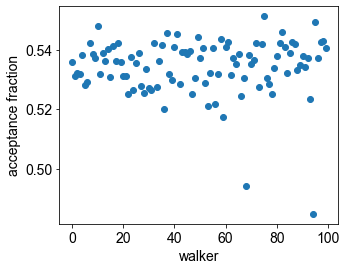

In [47]:
matplotlib.rcParams.update({"figure.figsize": (5,4)})
plt.plot(res.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

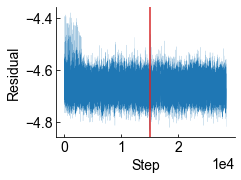

In [52]:
height = 1.9; 
scale_ratio = 2.45; 

fontSize=14
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})


fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.4))

plt.plot(range(len(res.flatchain)),res.flatchain.iloc[:,3],lw=0.1)
plt.axvline(x=15000,color='tab:red')
plt.xlabel('Step')
plt.ylabel('Residual')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
#plt.savefig('../M9Mal/M9Mal_chain.pdf', format='pdf', bbox_inches='tight')

In [ ]:
df2 = res.flatchain
df2.to_csv('../tmp/csv/M9Mal_v0_all.csv')

In [17]:
df2 = pd.read_csv('../tmp/csv/M9Mal_v0_all.csv', delimiter=',',index_col=0) 

In [18]:
df_all = df2.iloc[15000:,:]

In [55]:
print('\nError estimates from emcee:')
print('------------------------------------------------------')
print('Parameter  95%  67%   median  67%  95%')
for name in res.params.keys():
    quantiles = np.percentile(df_all[name],
                              [2.5, 16.5, 50, 83.5, 97.5])
    median = quantiles[2]
    err_m2 = quantiles[0] #- median
    err_m1 = quantiles[1] #- median
    err_p1 = quantiles[3] #- median
    err_p2 = quantiles[4] #- median 
    fmt = '  {:5s}   {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}'.format
    print(fmt(name, err_m2, err_m1, median, err_p1, err_p2))


Error estimates from emcee:
------------------------------------------------------
Parameter  95%  67%   median  67%  95%
  r         0.5086   0.5776   0.6455   0.7224   0.8085
  b        94.0559 114.1366 138.9081 171.7043 217.5740
  tau      45.5086  48.6629  51.9404  55.5101  59.3225
  __lnsigma    -4.7509  -4.7097  -4.6681  -4.6249  -4.5801


In [19]:
df_all2 = df_all.copy(deep=True);
df_all2.iloc[:,0] = df_all2.iloc[:,0]*1e-9;

In [20]:
best_params = [0.6342271623259587*1e-9,142.9565866036946, 51.80574403190663]

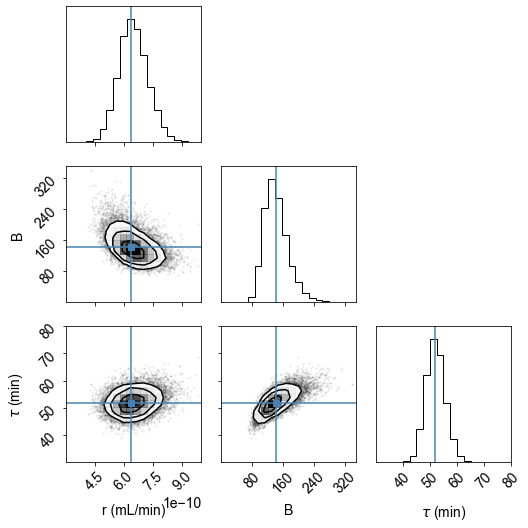

In [21]:
height = 1.9; 
scale_ratio = 2.45; 

fontSize=14
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})


import corner
matplotlib.rcParams.update({"figure.figsize": (8,8)})
emcee_plot = corner.corner(df_all2.iloc[:,:3], \
                           labels=['r (mL/min)','B',r'$\tau$ (min)'], \
                           range=[(0.3*1e-9,1.0*1e-9), (0.,350.),(30.,80.)], 
                           truths=best_params)
plt.tight_layout()
plt.savefig('../output/Sfig10c.pdf', format='pdf', bbox_inches='tight')

In [22]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook("../output/Sfig10c.xlsx")
writer = pd.ExcelWriter("../output/Sfig10c.xlsx", engine = 'xlsxwriter')

df_all2.to_excel(writer, sheet_name = 'Sfig10c')   

writer.close()

In [77]:
for i in range(3):
    name = titles[i]
    mean_ = np.mean(df_all.iloc[:,i])
    sem_ = np.std(df_all.iloc[:,i])
    fmt = '  {:5s}   {:8.4f} {:8.4f} '.format
    print(fmt(name, mean_, sem_))

  r         0.6496   0.0758 
  B       143.2021  31.4882 
  tau      52.0850   3.5389 


In [64]:
def check_boundary(para4, perc):
    flag = 1;
    for i in range(4):
        low_ = np.percentile(df_all.iloc[:,i],perc)
        high_ = np.percentile(df_all.iloc[:,i],100-perc)
        if para4[i] < low_ or para4[i] > high_:
            flag = 0; 
    return flag

def get_params(perc, num_of_param):
    count = 0;
    idx_all = np.zeros(num_of_param); 
    while (count <= num_of_param-1):
        idx_tmp = np.random.choice(len(df_all['r'])); 
        paras_tmp = df_all.iloc[idx_tmp,:4];
        flag = check_boundary(paras_tmp, perc)
        if flag == 1:
            idx_all[count] = idx_tmp;
            count = count + 1;
    return idx_all

In [81]:
idx_CI_95 = get_params(2.5, 200)

In [82]:
df_tmp = df_all.iloc[idx_CI_95,:]
df_tmp.to_csv('../tmp/csv/M9Mal_v0_CI95.csv')

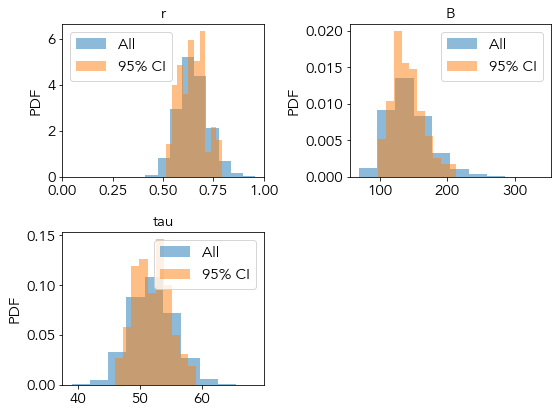

In [83]:
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

titles = ['r','B','tau']
matplotlib.rcParams.update({"figure.figsize": (8,6)})
for i in range(3):
    plt.subplot(2,2,i+1)
    plt.hist(df_all.iloc[:,i],alpha=0.5,label='All',density=True)
    plt.hist(df_tmp.iloc[:,i],alpha=0.5,label='95% CI',density=True)
    plt.ylabel('PDF')
    if i == 0:
        plt.xlim((0,1))
    plt.title(titles[i])
    plt.legend()
plt.tight_layout()

### start from here

In [23]:
df_tmp = pd.read_csv('../tmp/csv/M9Mal_v0_CI95.csv', delimiter=',',index_col=0) 


In [24]:
def simul_(ps):
    data_idx = 0; 
    i = 0; 
    all_cell_arr = {};
    
    ts = linspace(0,600,600);
    time_list_keys = list(time_list.keys())
    
    pk = 0; 
    for dataframe_key in time_list_keys: 
        time_cell = time_list[dataframe_key] - time_list[dataframe_key][0];
#        OD_cell = OD_list[dataframe_key]; 

        phage_0 = p0[pk]; 
        pk = pk+1; #phageOD_list[dataframe_key][0]; 
        
        x0 = [1, c0, 0, 0, 0, 0, 0, phage_0/1e9];
        x = odeint(f0, x0, ts, args=(ps,))

        all_CFU = x[:,1] + x[:,2] + x[:,3] + x[:,4] + x[:,5] + x[:,6]; 
        
        all_cell_tmp = all_CFU;
        all_phage_tmp = x[:,7] + ps[1]*x[:,6]; #0.5*ps[1]*(x[:,2] + x[:,3] + x[:,4] + x[:,5]+ x[:,6]); 
        
        max_time_cell = round(max(time_cell))
        
        all_cell_arr[dataframe_key] = all_cell_tmp[:max_time_cell]
        
    return all_cell_arr

In [25]:
def get_lower_and_upper_bound(idx_all):
    range_cell = {};
    range_phage = {};

    l_cell = {};
    h_cell = {};
    l_phage = {};
    h_phage = {};
    
    time_list_keys = list(time_list.keys());
    for dataframe_key in time_list_keys: 
        time_cell = time_list[dataframe_key] - time_list[dataframe_key][0];
        #time_phage = phagetime_list[dataframe_key];
        
        max_time_cell = round(max(time_cell))
        #max_time_phage = round(max(time_phage))
        
        range_cell[dataframe_key] = np.empty([len(idx_all),max_time_cell])
        #range_phage[dataframe_key] = np.empty([len(idx_all),max_time_phage])
    
    for j in range(len(idx_all)):
        #para_tmp = res.flatchain.iloc[int(idx_all[j]),:4];
        para_tmp = df_tmp.iloc[int(idx_all[j]),:3];
        all_cell_arr = simul_(para_tmp);
        for dataframe_key in time_list_keys: 
            range_cell[dataframe_key][j] = all_cell_arr[dataframe_key];
            #range_phage[dataframe_key][j] = all_phage_arr[dataframe_key];
    
    for dataframe_key in time_list_keys: 
        l_cell[dataframe_key] = np.min(range_cell[dataframe_key], axis=0);
        h_cell[dataframe_key] = np.max(range_cell[dataframe_key], axis=0);
        #l_phage[dataframe_key] = np.min(range_phage[dataframe_key], axis=0);
        #h_phage[dataframe_key] = np.max(range_phage[dataframe_key], axis=0);
    return(l_cell, h_cell)

In [26]:
(l_cell, h_cell) = get_lower_and_upper_bound(range(len(df_tmp)))

In [27]:
p_best = [0.6342271623259587, 142.9565866036946, 51.80574403190663]; 
(cell_best) = simul_(p_best);

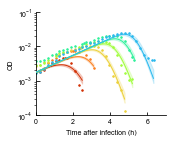

In [28]:
ts = np.linspace(0,600,600);

alpha_ = 0.02; 
marker_size_ = 1.5; 
colors_ = [1,1,2,2,3,3,4,4,5,5,6,6]
line_width_ = 1; 

colors=cm.turbo.reversed()(np.linspace(0,1,9))

alpha_ = 1; 
fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
height = 1.9; 
scale_ratio = 2.45; 

matplotlib.rcParams.update({"figure.figsize": (height*scale_ratio/2,height)})
ax = subplot(1,1,1)

i = 0; 
time_list_keys = list(time_list.keys());
for dataframe_key in time_list_keys[:12]: 
    time_cell = time_list[dataframe_key] - time_list[dataframe_key][0];
    max_time_cell = round(max(time_cell))
    OD_cell = OD_list[dataframe_key];
    if i in [0,2,4,6,8,10,12]:
        next;
    else:
        if i == 5:
            plt.plot(ts[:max_time_cell]/60, cell_best[dataframe_key][:max_time_cell], \
                 color=colors[colors_[i],:],\
                 linewidth=line_width_,alpha=alpha_,label='Model',zorder=10)
            plt.plot(time_cell[::1]/60, OD_cell[::1], 'o', \
                 markersize=marker_size_, \
                 color=colors[colors_[i],:],\
                label='Data',zorder=0)
        else:
            plt.plot(ts[:max_time_cell]/60, cell_best[dataframe_key][:max_time_cell],\
                 color=colors[colors_[i],:],\
                 linewidth=line_width_,zorder=10)
            plt.plot(time_cell[::1]/60, OD_cell[::1], 'o', \
                 markersize=marker_size_, \
                 color=colors[colors_[i],:],zorder=0)
        ax.fill_between(ts[:max_time_cell]/60, l_cell[dataframe_key], h_cell[dataframe_key], \
                  color=colors[colors_[i],:], alpha=0.2)
    
    i = i+1;
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")   

plt.xlabel('Time after infection (h)')
plt.ylim((1e-4,1e-1))
plt.yscale('log')
plt.ylabel('OD')
plt.xlim(0, 7)
plt.savefig('../output/Sfig10a.pdf', format='pdf', bbox_inches='tight')
#plt.tight_layout()

In [29]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook("../output/Sfig10a.xlsx")
writer = pd.ExcelWriter("../output/Sfig10a.xlsx", engine = 'xlsxwriter')

i = 0; 
time_list_keys = list(time_list.keys());
for dataframe_key in time_list_keys[:12]: 
    # obtain time list and OD list for cell
    time_cell = time_list[dataframe_key] - time_list[dataframe_key][0];
    max_time_cell = round(max(time_cell))
    OD_cell = OD_list[dataframe_key]; 

    if i in [0,2,4,6,8,10,12]:
        next;
    else:

        dftmptmp = pd.DataFrame({'Time after infection (h)':time_cell/60,\
                        'OD':OD_cell})
        dftmptmp = dftmptmp.T
        dftmptmp.to_excel(writer, sheet_name = 'data'+dataframe_key)   

    #########################
        dftmptmp = pd.DataFrame({'Time after infection (h)':ts[:max_time_cell]/60,\
                        'OD (best fit)':cell_best[dataframe_key][:max_time_cell],\
                        'OD (upper bound)':h_cell[dataframe_key],\
                        'OD (lower bound)':l_cell[dataframe_key]})
        dftmptmp = dftmptmp.T
        dftmptmp.to_excel(writer, sheet_name = 'fit'+dataframe_key)      

    i = i+1; 
writer.close()